# Install required libraries

In [137]:
import pandas as pd
import requests as req
import numpy as np
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans
!pip install folium
import folium
!pip install geopy
from geopy.geocoders import Nominatim



# Create pandas dataframe of the neighborhoods and associated latitudes and longitudes

In [2]:
URL = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans'
r= req.get(URL)
dfs = pd.read_html(URL)
df = dfs[0]
print(len(df.Neighborhood.unique()))
df.head()

72


,Neighborhood,Longitude,Latitude
0,U.S. NAVAL BASE,-90.026093,29.946085
1,ALGIERS POINT,-90.051606,29.952462
2,WHITNEY,-90.042357,29.947200
3,AUDUBON,-90.121450,29.932994
4,OLD AURORA,-90.000000,29.924440


# Define the latitude and longitude of New Orleans and create associated map

In [3]:
address = 'New Orleans'

geolocator = Nominatim(user_agent="geomap")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of New Orleans are 29.9499323, -90.0701156.


In [4]:
# create map of New Orleans using latitude and longitude values
map_no = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_no)  
    
map_no



# Using Foursquare get the top 100 venues in each neighbourhood in New Orleans, within a radius of 500 meters

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
#run the function to get the nearby venues, this will show the names of each neighbourhood as it is executed
no_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

U.S. NAVAL BASE
ALGIERS POINT
WHITNEY
AUDUBON
OLD AURORA
B. W. COOPER
BAYOU ST. JOHN
BEHRMAN
BLACK PEARL
BROADMOOR
MARLYVILLE - FONTAINEBLEAU
GERT TOWN
MID-CITY
ST. CLAUDE
CENTRAL BUSINESS DISTRICT
FRENCH QUARTER
CENTRAL CITY
LAKE CATHERINE
VILLAGE DE LEST
VIAVANT - VENETIAN ISLES
NEW AURORA - ENGLISH TURN
TALL TIMBERS - BRECHTEL
FISCHER DEV
McDONOGH
LOWER GARDEN DISTRICT
ST. THOMAS DEV
EAST RIVERSIDE
IRISH CHANNEL
TOURO
MILAN
UPTOWN
WEST RIVERSIDE
EAST CARROLLTON
FRERET
GARDEN DISTRICT
LEONIDAS
HOLLYGROVE
TULANE - GRAVIER
TREME - LAFITTE
SEVENTH WARD
MARIGNY
ST. ROCH
DIXON
LAKEWOOD
NAVARRE
CITY PARK
LAKEVIEW
WEST END
LAKESHORE - LAKE VISTA
FILMORE
ST. BERNARD AREA
DILLARD
ST. ANTHONY
LAKE TERRACE & OAKS
MILNEBURG
PONTCHARTRAIN PARK
GENTILLY WOODS
GENTILLY TERRACE
DESIRE AREA
FLORIDA AREA
FLORIDA DEV
LOWER NINTH WARD
BYWATER
HOLY CROSS
PINES VILLAGE
PLUM ORCHARD
READ BLVD WEST
READ BLVD EAST
WEST LAKE FOREST
LITTLE WOODS
FAIRGROUNDS
IBERVILLE


In [8]:
print(len(no_venues.Neighborhood.unique()))
print(len(df['Neighborhood']))
print(no_venues.shape)
no_venues.head()

67
72
(904, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,U.S. NAVAL BASE,29.946085,-90.026093,The Mighty Missisippi,29.949695,-90.023710,Boat or Ferry
1,ALGIERS POINT,29.952462,-90.051606,Tout de Suite Café,29.952121,-90.051090,Café
2,ALGIERS POINT,29.952462,-90.051606,Congregation Coffee Roasters,29.951918,-90.053395,Coffee Shop
3,ALGIERS POINT,29.952462,-90.051606,The Crown & Anchor,29.951416,-90.054220,Bar
4,ALGIERS POINT,29.952462,-90.051606,Levee @ Algiers Point,29.951760,-90.048747,Scenic Lookout


In [9]:
#It appears that some of the original neghborhoods (72) did not get included in the determination of no_venues ((66))
#Reduce df to include only the neighborhoods for which venue categories and venues were determined.

df = df[df['Neighborhood'].isin(no_venues.Neighborhood)]
print(len(df['Neighborhood']))

67


## Apply onehotencoding to 'Venue Category' to show how many of each Venue Category is in each neighborhood

In [66]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [11]:

no_onehot = pd.get_dummies(no_venues[['Venue Category']], prefix="", prefix_sep="")
# add the neighborhood column to dataframe
no_onehot['Neighborhood'] = no_venues['Neighborhood'] 

# move neighborhood column to the first column
no_onehot = no_onehot[ ['Neighborhood'] + [ col for col in no_onehot.columns if col != 'Neighborhood' ] ]

no_onehot.head()



,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Dance Studio,Deli / Bodega,Dessert Shop,Discount Store,Dive Bar,Donut Shop,Eastern European Restaurant,Entertainment Service,Ethiopian Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Frame Store,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Light Rail Station,Locksmith,Lounge,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Street Art,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Trail,Travel & Transport,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,U.S. NAVAL BASE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ALGIERS POINT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Now reduce the onehot encoding of the venue categories to yoga studios and those related to beverage venues:

In [170]:
no_onehot2 = no_onehot[['Neighborhood', 'Yoga Studio', 'Café', 'Coffee Shop', 'Juice Bar', 'Smoothie Shop']]
no_grouped = no_onehot2.groupby('Neighborhood').mean().reset_index()
no_grouped.head()

,Neighborhood,Yoga Studio,Café,Coffee Shop,Juice Bar,Smoothie Shop
0,ALGIERS POINT,0.0,0.045455,0.045455,0.0,0.000000
1,AUDUBON,0.0,0.000000,0.142857,0.0,0.142857
2,B. W. COOPER,0.0,0.000000,0.000000,0.0,0.000000
3,BAYOU ST. JOHN,0.0,0.000000,0.000000,0.0,0.000000
4,BLACK PEARL,0.0,0.000000,0.000000,0.0,0.000000


## Also show the sum of each of the of the above venue categories in each neighborhood:

In [169]:
no_count = no_onehot2.groupby('Neighborhood').sum().reset_index()
no_count.head()

,Neighborhood,Yoga Studio,Café,Coffee Shop,Juice Bar,Smoothie Shop
0,ALGIERS POINT,0,1,1,0,0
1,AUDUBON,0,0,1,0,1
2,B. W. COOPER,0,0,0,0,0
3,BAYOU ST. JOHN,0,0,0,0,0
4,BLACK PEARL,0,0,0,0,0


## Now show for each neighborhood the frequency of yoga studios relative to coffe shop and related venues

In [171]:
num_top_venues = 5

for hood in no_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = no_grouped[no_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')



----ALGIERS POINT----
           venue  freq
0  Café           0.05
1  Coffee Shop    0.05
2  Yoga Studio    0.00
3  Juice Bar      0.00
4  Smoothie Shop  0.00


----AUDUBON----
           venue  freq
0  Coffee Shop    0.14
1  Smoothie Shop  0.14
2  Yoga Studio    0.00
3  Café           0.00
4  Juice Bar      0.00


----B. W. COOPER----
           venue  freq
0  Yoga Studio    0.0 
1  Café           0.0 
2  Coffee Shop    0.0 
3  Juice Bar      0.0 
4  Smoothie Shop  0.0 


----BAYOU ST. JOHN----
           venue  freq
0  Yoga Studio    0.0 
1  Café           0.0 
2  Coffee Shop    0.0 
3  Juice Bar      0.0 
4  Smoothie Shop  0.0 


----BLACK PEARL----
           venue  freq
0  Yoga Studio    0.0 
1  Café           0.0 
2  Coffee Shop    0.0 
3  Juice Bar      0.0 
4  Smoothie Shop  0.0 


----BROADMOOR----
           venue  freq
0  Coffee Shop    0.2 
1  Yoga Studio    0.0 
2  Café           0.0 
3  Juice Bar      0.0 
4  Smoothie Shop  0.0 


----BYWATER----
           venue  freq
0

In [172]:
#put the above into a sorted Pandas dataframe:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5 #We have reduced the number of possible venues to 5 given reducing venue categories to 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = no_grouped['Neighborhood']

for ind in np.arange(no_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(no_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ALGIERS POINT,Coffee Shop,Café,Smoothie Shop,Juice Bar,Yoga Studio
1,AUDUBON,Smoothie Shop,Coffee Shop,Juice Bar,Café,Yoga Studio
2,B. W. COOPER,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio
3,BAYOU ST. JOHN,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio
4,BLACK PEARL,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio


## Cluster the Neighborhoods in New Orleans

In [173]:
#run K-means to cluster the neighborhoods.  Start with 5 clusters
kclusters = 5

no_grouped_clustering = no_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(no_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([0, 4, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 1, 0,
       2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 3, 2, 0, 2, 0, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 0, 2, 2, 0,
       2], dtype=int32)

In [174]:
#create a new dataframe that includes the cluster as well as the 5 most common venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

no_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
no_merged = no_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

no_merged.head() # check the last columns!

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,U.S. NAVAL BASE,-90.026093,29.946085,2,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio
1,ALGIERS POINT,-90.051606,29.952462,0,Coffee Shop,Café,Smoothie Shop,Juice Bar,Yoga Studio
2,WHITNEY,-90.042357,29.947200,2,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio
3,AUDUBON,-90.121450,29.932994,4,Smoothie Shop,Coffee Shop,Juice Bar,Café,Yoga Studio
4,OLD AURORA,-90.000000,29.924440,2,Smoothie Shop,Juice Bar,Coffee Shop,Café,Yoga Studio


In [175]:
#visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(no_merged['Latitude'], no_merged['Longitude'], no_merged['Neighborhood'], no_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Determine how many yoga studios there are in each cluster and plot this with the associated beverage venues in each cluster

In [176]:
no_merged_cluster = no_merged[['Neighborhood','Cluster Labels']]
no_count_clust = no_merged_cluster.join(no_count.set_index('Neighborhood'),on='Neighborhood').groupby('Cluster Labels').sum().reset_index()

no_count_clust

,Cluster Labels,Yoga Studio,Café,Coffee Shop,Juice Bar,Smoothie Shop
0,0,1,9,22,2,1
1,1,1,1,6,1,0
2,2,4,4,3,2,0
3,3,0,9,7,0,0
4,4,0,0,1,0,2


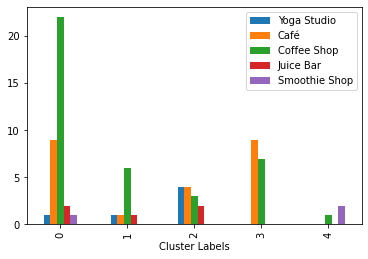

In [178]:
no_count_clust.plot(x='Cluster Labels',y=['Yoga Studio', 'Café', 'Coffee Shop', 'Juice Bar', 'Smoothie Shop'],kind='bar')

## The plot above suggests that Cluster 2 might be a location to consider for a new beverage venue given the relative density of yoga studios. However, there are only a total of (6) yoga studios in New Orleans and further Cluster 2 encompases a significant area of New Orleans.  Accordingly, it is not possible to determine with this info where a new beverage venue should be located.  Since there are only (6) studios it will be easy and much more useful to focus directly on the New Orleans Neighborhoods that have Yoga Studios.

In [179]:
#Look only at the neighborhoods that have the (6) yoga studios.
no_count_neigh = no_count[no_count['Yoga Studio']!=0]
no_count_neigh['Studio to Venue'] = no_count_neigh['Yoga Studio'] / (no_count_neigh[['Café', 'Coffee Shop', 'Juice Bar', 'Smoothie Shop']].sum(axis=1))
no_count_neigh['Studio to Venue']=no_count_neigh['Studio to Venue'].round(decimals=2)
no_count_neigh

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Neighborhood,Yoga Studio,Café,Coffee Shop,Juice Bar,Smoothie Shop,Studio to Venue
14,EAST RIVERSIDE,1,0,0,1,0,1.00
20,FRERET,1,1,4,1,0,0.17
34,LEONIDAS,2,1,0,0,0,2.00
58,TOURO,1,0,1,1,0,0.50
62,UPTOWN,1,1,1,0,0,0.50


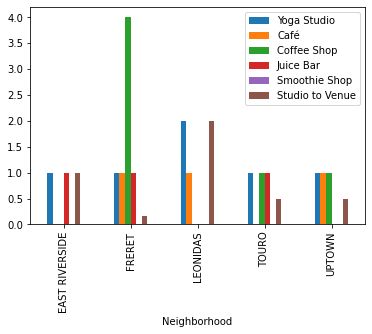

In [180]:
no_count_neigh.plot(x='Neighborhood',y=['Yoga Studio', 'Café', 'Coffee Shop', 'Juice Bar', 'Smoothie Shop','Studio to Venue'],kind='bar')

# In the above plot, the ratio of Yoga Studios to beverage locations is highest in the neighborhood of Leonidas with a value of (2.0).  This suggests that this neighborhood may be a candidate to consider opening a new tea house in.  Further exploration and metrics need to be considered in future work, this observation provides a potential starting point for that work.